In [98]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
import pandas as pd
import numpy as np


#### NOTE: Please download the below library IF you don't already have it installed: 


In [99]:

#Please download these libraries if you don't have them
#%pip install PyPortfolioOpt


In [100]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import cvxpy as cp
from pypfopt import BlackLittermanModel



## Group Assignment
### Team Number: 14
### Team Member Names: Aadya, Furqan, Pranay
### Team Strategy Chosen: Market Beat

### Hello! 
- We hope you’re having a good day so far and that you enjoy running our model! 

#### Note 
 - Our file might encounter a yFinance error that states it is not able to pull a given ticker. In that case, restart the kernel and rerun.  
 
#### Brief overview of our strategy:

After cleaning our csv file for valid tickers, our strategy is to score and then sort our tickers in increasing order based on 4 quantitative metrics - Alpha, Sortino, Momentum, and Beta. This will pick the 10 best stocks (top 10) for our model. We will then use Black-Litterman Model to optimize the weightings of these 10 stocks to beat the benchmark average with long-term range in mind. We will delve more into our reasoning for our choices in the below, in our code and markdown. We are also going to be using 3 year historical data to calculate metrics and optimize.

To get started, please input your csv with tickers. We’re sure you know where to input your csv file, but as due diligence, replace _INSERT_CSV_ in the code block below. 

Please note that the program is subject to the yfinance API's functionality, so if there is errors correlated to issues from the API's side, please just rerun the code, for it to reaccess yfinance, run again and work!

In [ ]:

input_tickers = pd.read_csv("INSERT_CSV_HERE", names=['Tickers']) #OR any other CSV file with tickers in it
input_tickers

,Tickers
0,AAPL
1,MSFT
2,GOOGL
3,AMZN
4,META
...,...
150,0700.HK
151,NESN.SW
152,SAP.DE
153,ASML.AS


In [102]:
## PRELIMINARY DATA PROCESSING 
## AND INPUT PROCESSING

## Check if implementation of US and Canadian ticker validation is sufficient/correct
## Should we do it through currency checks, or exchange checks as below?

def validate_ticker(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        if info and 'regularMarketPrice' in info:
            if 'exchange' in info:
                exchange = info['exchange']
                # yfinance uses these exchange codes, so we check against them to see if they are in US/Canadian markets/exchanges
                valid_exchanges = ['NMS', 'NGM', 'NYQ','NAD','PCX','BTS','CBQ','ASE', 'TOR', 'TSE', 'Toronto', 'TSXV', 'CNQ', 'CSE','NEO']
                if exchange in valid_exchanges:
                    return True
                else:
                    return False  
            else:
                return False  
        else:
            return False
    except:
        return False

# Valid tickers go in new list to be passed on
valid_tickers = []
for ticker in input_tickers['Tickers']:
    if validate_ticker(ticker):
        valid_tickers.append(ticker)
    else:
        print(f"Invalid ticker: {ticker}")

valid_tickers_df = pd.DataFrame(valid_tickers, columns=['Ticker'])
valid_tickers_df


Invalid ticker: SQ
Invalid ticker: PLUG
Invalid ticker: NKLA
Invalid ticker: FSR
Invalid ticker: WKHS
Invalid ticker: BLNK
Invalid ticker: SNDL


HTTP Error 404: 


Invalid ticker: MULN
Invalid ticker: GEVO
Invalid ticker: AGN
Invalid ticker: CELG
Invalid ticker: MON
Invalid ticker: RTN


HTTP Error 404: 


Invalid ticker: YHOO
Invalid ticker: TWX
Invalid ticker: 9984.T
Invalid ticker: RELIANCE.NS
Invalid ticker: INFY.NS
Invalid ticker: MC.PA
Invalid ticker: CPA.AX
Invalid ticker: 0700.HK
Invalid ticker: NESN.SW
Invalid ticker: SAP.DE
Invalid ticker: ASML.AS


,Ticker
0,AAPL
1,MSFT
2,GOOGL
3,AMZN
4,META
...,...
126,UPS
127,LMT
128,RTX
129,MMM


In [103]:
# check if duplicates exist in the csv and remove them
def check_duplicates(df):
    duplicates = df.duplicated()

    for index in duplicates.index:
        if duplicates[index] == True:
            print(f"Removing duplicate: {df.loc[index, 'Ticker']}")
            df.drop(index, inplace=True)
    return df.reset_index().drop(columns=['index'])

check_duplicates(valid_tickers_df)

,Ticker
0,AAPL
1,MSFT
2,GOOGL
3,AMZN
4,META
...,...
126,UPS
127,LMT
128,RTX
129,MMM


#### Note on Functionality

We have chosen to take out companies that have IPO'd after September 30th, 2025 as they don't have enough data to satisfy volume requirement. If a company does IPO in the window (October 10th, 2024 - September 30th, 2025), we decided to exclude them as well since there is much uncertainity about firms that have IPOd recently. Investing in an IPO depends on your belief of the company and the industries future outlook. We don't have enough insight into the companies role in the market, and due to that have decided that it's better to not include these tickers in our model, which is better for marking long-term stocks. These companies also have low liquidty, which is unfavourable for us. 

In [104]:
## REMOVING STOCKS WITH AVG TRADE VOLUME < 5000 between Oct 1, 2024 and Sep 30, 2025 (also dropping months with < 18 trading days).
##CHECK to ensure, and filter out stocks that do not meet this criteria

def filter_by_avg_volume(df, start_date="2024-10-01", end_date="2025-09-30", min_avg_volume=5000, min_trading_days=18):
    filtered_tickers = []
    for ticker in df['Ticker']:
        stock = yf.Ticker(ticker)
        

        hist = stock.history(start=start_date, end=end_date)

        if hist.empty:
            print(f"Ticker IPO'd after analysis period, thus did not meet trading volume criteria, REMOVED: {ticker}")
            continue

        hist.index = hist.index.tz_localize(None)

        first_date = hist.index[0].date()
        start_date_obj = pd.to_datetime(start_date).date()

        if first_date > start_date_obj:
            print(f"{ticker} IPO'd on {first_date} - within the window, thus removed and not included in volume analysis.")
            continue

        monthly_groups = hist.groupby(hist.index.to_period("M"))
        valid = True

        # Checking each month's average volume and trading days to ensure we meet requirments
        for month, group in monthly_groups:
            trading_days = len(group)
            if trading_days >= min_trading_days:
                avg_volume = group['Volume'].mean()
                if avg_volume < min_avg_volume:
                    print(f"Ticker failed volume filter: {ticker} (Avg Volume: {avg_volume:.2f} in {month})")
                    valid = False
                    break
        if valid:
            print(f"Ticker passed volume filter: {ticker}")
            filtered_tickers.append(ticker)
    return pd.DataFrame(filtered_tickers, columns=['Ticker'])

final_tickers_df = filter_by_avg_volume(valid_tickers_df)
final_tickers_df


Ticker passed volume filter: AAPL
Ticker passed volume filter: MSFT
Ticker passed volume filter: GOOGL
Ticker passed volume filter: AMZN
Ticker passed volume filter: META
Ticker passed volume filter: TSLA
Ticker passed volume filter: NVDA
Ticker passed volume filter: JPM
Ticker passed volume filter: JNJ
Ticker passed volume filter: V
Ticker passed volume filter: WMT
Ticker passed volume filter: PG
Ticker passed volume filter: UNH
Ticker passed volume filter: MA
Ticker passed volume filter: HD
Ticker passed volume filter: DIS
Ticker passed volume filter: BAC
Ticker passed volume filter: XOM
Ticker passed volume filter: CVX
Ticker passed volume filter: PFE
Ticker passed volume filter: ABBV
Ticker passed volume filter: CSCO
Ticker passed volume filter: MRK
Ticker passed volume filter: PEP
Ticker passed volume filter: COST
Ticker passed volume filter: AVGO
Ticker passed volume filter: NFLX
Ticker passed volume filter: ADBE
Ticker passed volume filter: CRM
Ticker passed volume filter: INTC


,Ticker
0,AAPL
1,MSFT
2,GOOGL
3,AMZN
4,META
...,...
126,UPS
127,LMT
128,RTX
129,MMM


In [105]:
#Downloading history (3y) for valid tickers and market

tickers_list =  valid_tickers_df['Ticker'].tolist()

stock_data= yf.download(tickers_list, period="3y", interval="1d", group_by='ticker', auto_adjust=True, threads=True)

sp500_data = yf.download('^GSPC', period='3y', auto_adjust=True)
tsx_data = yf.download('^GSPTSE', period='3y', auto_adjust=True)

if isinstance(sp500_data, pd.DataFrame):
    sp500 = sp500_data['Close'].squeeze() 
else:
    sp500 = sp500_data

if isinstance(tsx_data, pd.DataFrame):
    tsx = tsx_data['Close'].squeeze()  
else:
    tsx = tsx_data

sp500.index = sp500.index.tz_localize(None)
tsx.index = tsx.index.tz_localize(None)


[*********************100%***********************]  131 of 131 completed

2 Failed downloads:
['DDOG']: Timeout('Failed to perform, curl: (28) Connection timed out after 10009 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['NTR.TO']: Timeout('Failed to perform, curl: (28) Operation timed out after 10004 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Stock Selection (following chunks of code before portfolio validation)

#### Overview 
Our first main strategy is to score the valid tickers and rank them based on their scores. The scores are calculated by 4 quantitative metrics - Alpha, Sortino, Momentum, and Beta. From the result of scoring, the top 10 stocks are picked which are our choices for our portfolio (if they don’t conflict with portfolio validation). 

#### Metrics 

From our lessons, we know beta is the measure of risk relative to the market and sharpe ratio is the measure of risk adjusted returns for the total volatility of an asset. Both beta and sharpe can be used to calculate two more quantitative metrics - Alpha and Sortino. 

##### 1) Beta 

Measure of returns compared to the market, which is what we are trying to beat.  

 $$ \beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)} $$

Where:  

- $R_i$ = returns of the individual asset  
- $R_m$ = returns of the overall market (benchmark)  
- $\mathrm{Cov}(R_i, R_m)$ = covariance between the asset’s returns and the market’s returns  
- $\mathrm{Var}(R_m)$ = variance of the market’s returns  


 ##### 2) Jensen's Alpha

Measures the excess returns over the market, taking beta into consideration in the calculation.

$$
\alpha = R_i - \left( R_f + \beta \left( R_m - R_f \right) \right)
$$

Where:

- $R_i$ — the actual return of the stock or portfolio  
- $R_f$ — the risk-free rate (e.g., treasury yield)  
  - We use an annual risk-free rate of **0.04 (4%)**, which all alpha values are based on.  
- $R_m$ — the return of the overall market or chosen benchmark  
- $\beta_i$ — the stock’s sensitivity to market movements (systematic risk) 

Intuitevely:

- $\alpha$ > 0: Means positive returns relative to the market 
- $\alpha$ = 0: The investment's return was in line with the benchmark index
- $\alpha$ < 0: The investment's performance was worse than its benchmark index

##### 3) Sortino Ratio

measures excess return relative to harmful (downside) volatility.
It is a variation of the Sharpe ratio, but it only penalizes negative returns.

$$
\text{Sortino} = \frac{R_p - R_f}{\sigma_d}
$$

Where:

- $R_p$ — the actual return of the portfolio or stock  

- $R_f$ — the risk-free rate (minimum acceptable return)  
  - We use an annual risk-free rate of **0.04**, which we divide by **252 trading days** to obtain the daily $R_f$ used in Sortino.  

- $\sigma_d$ — the downside deviation, which measures only negative volatility  
  (returns that fall below $R_f$)

Intuitevely:

- Sortino > 0: good risk-adjusted performance with limited downside risk  
- Sortino = 0: no excess return relative to downside risk  
- Sortino < 0: poor risk-adjusted performance with significant downside risk  

Note:
- We chose sortino over sharpe as sortino only penalises negative volatility while sharpe penalises both negative and positive volatility, which allows us to pick stocks that show high returns with minimal drawdowns. In essence, having a high alpha and a high sortino in a long-term period should beat the market as it maximises returns and minimises risk, naturally prioritising stocks that are stable long-term outperformers. 


##### 4) Momentum

Our final metric is momentum, which we chose to give us insight into short term movement of the stocks. This is helpful as it highlights the stocks that are doing well right now, allowing us to take that into account to better pick stocks for the scope of this project. 


$$
\text{Momentum} = \left( \frac{R_t}{R_{t-n}} \right) - 1
$$

Where:

- $R_t$ — the price or return of the stock at time $t$
- $R_{t-n}$ — the price or return $n$ periods ago
- $n$ — the lookback period



In [106]:
#assuming we have a list of valid tickers
#we need a function that simply returns the alpha of a ticker
#then run a for loop that calls that function for every ticker
#while ranking it from best to worst in a list or dictionary maybe
#going to also assume we have the portfolio returns, risk free rate, expected market return, and the portfolio beta


# calculates beta of a stock 
# beta is cov (Rp, Rm) / var (Rm)
def calc_beta(ticker_returns, market_returns):
    covariance = ticker_returns.cov(market_returns)
    variance = market_returns.var()
    beta = covariance / variance
    return beta

#function to calculate alpha of a ticker given the following parameters
#returns the ticker and its alpha in a list
#Good alpha > 0; Means positive returns relative to the market
#Zero alpha (\(\alpha =0\)): The investment's return was in line with the benchmark index, meaning it did not outperform or underperform after adjusting for risk.
#Negative alpha (\(<0\)): The investment's performance was worse than its benchmark index, considering the risk taken. 
def calc_alpha(portfolio_return, risk_free_rate, expected_market_return, portfolio_beta): 
    tick_alpha_calculation = portfolio_return - (risk_free_rate + (portfolio_beta * (expected_market_return-risk_free_rate)))

    return tick_alpha_calculation

# calculating sharpe ratio 
# sharpe ratio of a stock is = (Rp - Rf) / σp
# Good sharpe ratio > 1: indicates good risk-adjusted performance
# Average sharpe ratio ~ 0.5 - 1: indicates moderate risk-adjusted performance
# Poor sharpe ratio < 0.5: indicates poor risk-adjusted performance
# if ticker_returns are daily, then risk free has to be daily as well
def calc_sharpe(ticker_returns, risk_free_rate):
    std = ticker_returns.std()
    mean_return = ticker_returns.mean()
    sharpe_ratio = (mean_return - risk_free_rate) / std
    return sharpe_ratio

# calculating sortino ratio 
# sortino ratio = (Rp - Rf) / σd when σd is the standard deviation of negative asset returns
# sortino ratio focuses only on downside volatility which helps eliminate 
# the risk of downside movements in asset prices
# Intuitively good return per unit of bad volatility
# Good sortino ratio > 0: good risk-adjusted performance with low downside 
# Zero sortino ratio = 0: no excess return relative to downside risk
# Low sortino ratio < 0: poor risk-adjusted performance with high downside risk
def calc_sortino(ticker_returns, risk_free_rate):
    downside_dev = ticker_returns[ticker_returns < 0].std()
    mean_return = ticker_returns.mean()
    sortino_ratio = (mean_return - risk_free_rate) / downside_dev
    return sortino_ratio


##Calculating momentum, shows how much a stock has returned relative to a chosen date/period a while back
#Determining the change in return a given stock has had over a given period of time can aid in picking
#stocks that are trending upwards
def calc_momentum(ticker_returns, period):
    momentum = (ticker_returns.iloc[-1]/ticker_returns.iloc[-period]) - 1
    return momentum

In [107]:
sp500_aligned, tsx_aligned = sp500.align(tsx, join='inner')

# HERE IS OUR BENCHMARK: Simple arthmetic average of S&P 500 and TSX
#Utilized for our comparitive metrics like Alpha
benchmark_prices = (sp500_aligned + tsx_aligned) / 2
benchmark_returns = benchmark_prices.pct_change().dropna()

risk_free_rate_sortino = 0.04 / 252  # Daily risk-free rate assuming 4% annual
risk_free_rate_alpha = 0.04  # Annual risk-free rate for alpha calculation

years = 3 
market_total_return = (benchmark_prices.iloc[-1] / benchmark_prices.iloc[0]) - 1
market_actual_return = (1 + market_total_return) ** (1/years) - 1  # ANNUALIZED RETURN

## Will build loop though stock_data[] and as it goes through each ticker we can calculate the relevant metrics for those tickers
##Apply created functions for metrics to the tickers while we iterate through the loop

stock_results = []

for ticker in tickers_list:
    stock_close = stock_data[ticker]['Close'].dropna()

    #Skipping tickers with insufficient data for momentum calculation
    #If for some reaosn it has less than 63 trading days worth of data it may be a penny stock, have its stock halted long periods, be delisted or there are data issues
    #All of which mean we can skip it and don't want to invest in it anyway
    if len(stock_close) < 63:
        print(f"{ticker}: Only {len(stock_close)} days of data (need 63 for momentum). Skipping.")
        continue

    stock_close.index = stock_close.index.tz_localize(None)
    stock_returns = stock_close.pct_change().dropna()

    beta = calc_beta(stock_returns, benchmark_returns)

    
    stock_total_return = (stock_close.iloc[-1] / stock_close.iloc[0]) - 1
    stock_actual_return = (1 + stock_total_return) ** (1/years) - 1


    alpha = calc_alpha(stock_actual_return, risk_free_rate_alpha, market_actual_return, beta)

    sortino = calc_sortino(stock_returns, risk_free_rate_sortino)
    momentum = calc_momentum(stock_close, period=63) #3 months
    
    stock_results.append({
        'Ticker': ticker,
        'Alpha': alpha,
        'Beta': beta,
        'Sortino': sortino,
        'Return': stock_actual_return,
        'Momentum': momentum
    })

results_df = pd.DataFrame(stock_results)

#Sorting results by alpha value, highest to lowest, so we can see ideal stocks to invest in
results_df = results_df.sort_values('Alpha', ascending=False)

print("\n=== Top Stocks by Alpha ===")
results_df.reset_index(drop=True, inplace=True)
results_df

NTR.TO: Only 0 days of data (need 63 for momentum). Skipping.
DDOG: Only 0 days of data (need 63 for momentum). Skipping.

=== Top Stocks by Alpha ===


,Ticker,Alpha,Beta,Sortino,Return,Momentum
0,PLTR,1.474593,2.415736,0.198009,1.778378,-0.037421
1,NVDA,0.987490,1.901946,0.178275,1.235172,-0.015844
2,SPOT,0.812110,1.165934,0.167177,0.979424,-0.162046
3,AVGO,0.657378,1.768026,0.151730,0.890437,0.143528
4,GE,0.578550,1.209652,0.176070,0.750637,0.050563
...,...,...,...,...,...,...
124,BBBY,-0.701462,2.536769,-0.020402,-0.384460,-0.415352
125,LCID,-0.770865,2.070134,-0.061141,-0.504818,-0.417062
126,AMC,-0.893840,1.508789,-0.064084,-0.689088,-0.230769
127,CHPT,-0.993286,2.544930,-0.098168,-0.675393,-0.321244


#### Scoring 

Since our portfolio’s aim is to beat the market in long-term time span, our sorting strategy scores stocks based on the following weights: 

$$
\text{Score} = 0.30 \alpha + 0.35\,\text{Sortino} + 0.30\,\text{Momentum} + 0.05 \beta
$$


These weightings are optimal for our strategy as alpha and momentum prioritise the growth and the returns of the stock while sortino and beta are both risk adjusted metrics. These weightings are optimal because they allow our model to maximize return generating factors while still maintaining control over downside risk, creating a portfolio that theoretically compounds more than the market in the long run. 

The scoring function generates a dataframe with all tickers sorted from best to last, so the ticker with the lowest score (highest in the sorted list) is the best ticker. Then the top 10 stocks from this dataframe are chosen to be in our initial portfolio. 

Sources - 

[Understanding Momentum — Alpha Architect](https://alphaarchitect.com/understanding-momentum/)

[Performance Metrics, Risk Metrics & Strategy Optimisation — QuantInsti](https://blog.quantinsti.com/performance-metrics-risk-metrics-optimization/)



In [108]:
##USING METRICS TO PICK TOP x STOCKS TO INVEST IN

results_df['Alpha_rank'] = results_df['Alpha'].rank(ascending=False)
results_df['Sortino_rank'] = results_df['Sortino'].rank(ascending=False)
results_df['Momentum_rank'] = results_df['Momentum'].rank(ascending=False)

##Beta close to 1.15 is ideal, so we rank based on distance from 1.15
##ascending True means closest to 1.15 gets rank 1, lowest distance to greatest distance
results_df['Beta_rank'] = (results_df['Beta'] - 1.15).abs().rank(ascending=True)

# Score (simple sum - equal weight)
# Different metrics are weighted differently
# Alpha: 30%
# Sortino: 35%
# Momentum: 30%
# Beta: 5%
# This is because sortino is considered more important for risk-adjusted returns
# momentum and alpha are growth indicators 
results_df['Composite_Score'] = (
    (0.30 * results_df['Alpha_rank']) + 
    (0.35 * results_df['Sortino_rank']) + 
    (0.30 * results_df['Momentum_rank']) + 
    (0.05 * results_df['Beta_rank'])
)

# Here is a dataframe with just ranks and composite score
scored_df = results_df[['Ticker', 'Alpha_rank', 'Sortino_rank', 'Momentum_rank', 'Beta_rank', 'Composite_Score']].copy()

# Sorted by composite score
scored_df = scored_df.sort_values('Composite_Score')

scored_df.reset_index(drop=True, inplace=True)

scored_df


,Ticker,Alpha_rank,Sortino_rank,Momentum_rank,Beta_rank,Composite_Score
0,GOOGL,13.0,9.0,1.0,24.0,8.55
1,ABX.TO,16.0,17.0,3.0,29.0,13.10
2,LLY,10.0,20.0,2.0,77.0,14.45
3,AVGO,4.0,6.0,24.0,89.0,14.95
4,CAT,22.0,16.0,8.0,53.0,17.25
...,...,...,...,...,...,...
124,GPRO,124.0,113.0,113.0,116.0,116.45
125,BBBY,125.0,108.0,127.0,123.0,119.55
126,AMC,127.0,125.0,119.0,67.0,120.90
127,LCID,126.0,124.0,128.0,110.0,125.10


In [109]:
## TOP X STOCKS TO INVEST IN BASED ON METRICS ##
num_stocks_to_invest = 10

top_x_stocks_beforeCHECK = scored_df.head(num_stocks_to_invest)
top_x_stocks_beforeCHECK

,Ticker,Alpha_rank,Sortino_rank,Momentum_rank,Beta_rank,Composite_Score
0,GOOGL,13.0,9.0,1.0,24.0,8.55
1,ABX.TO,16.0,17.0,3.0,29.0,13.10
2,LLY,10.0,20.0,2.0,77.0,14.45
3,AVGO,4.0,6.0,24.0,89.0,14.95
4,CAT,22.0,16.0,8.0,53.0,17.25
5,MFC.TO,21.0,13.0,20.0,19.0,17.80
6,GE,5.0,3.0,54.0,18.0,19.65
7,CRWD,11.0,22.0,19.0,73.0,20.35
8,BABA,27.0,29.0,9.0,11.0,21.50
9,ISRG,28.0,28.0,16.0,25.0,24.25


#### Visualising Our Stock Selection

The scatter plot below graphs the composite scores of our valid tickers. The scores that are highlighted in the green are the ones that are selected for our initial portfolio (before portfolio validation checks).  The y-axis represents the composite scores ranging from 0 to 100, and the x-axis represents the stock ranking. The plot shows that having a lower score is better. The red line is the cutoff for top 10 and everything below that represents the stocks that we didn’t pick. This shows that we are picking the best top 10 from our list of valid tickers to create a portfolio.

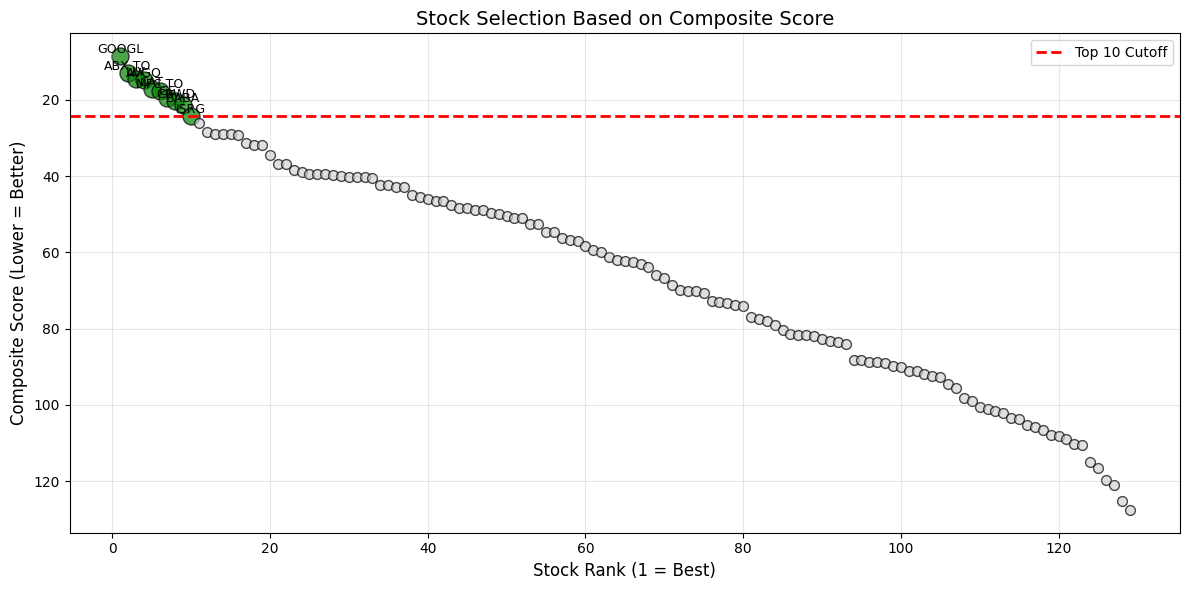

In [110]:
# Add a column to track which stocks we selected
scored_df['Selected'] = scored_df['Ticker'].isin(top_x_stocks_beforeCHECK['Ticker'])
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in scored_df.iterrows():
    if row['Selected']:
        ax.scatter(i+1, row['Composite_Score'], color='green', s=150, alpha=0.7, edgecolors='black')
        ax.text(i+1, row['Composite_Score'], row['Ticker'], fontsize=9, ha='center', va='bottom')
    else:
        #made the unselected stocks grey and smaller
        ax.scatter(i+1, row['Composite_Score'], color='lightgray', s=50, alpha=0.7, edgecolors='black')

#Cutoff line indicating from where the top stocks were selected
cutoff_score = scored_df['Composite_Score'].iloc[num_stocks_to_invest-1]
ax.axhline(y=cutoff_score, color='red', linestyle='--', linewidth=2, label=f'Top {num_stocks_to_invest} Cutoff')

ax.set_xlabel('Stock Rank (1 = Best)', fontsize=12)
ax.set_ylabel('Composite Score (Lower = Better)', fontsize=12)
ax.set_title('Stock Selection Based on Composite Score', fontsize=14)
ax.invert_yaxis()  # We flipped here so lower scores are at top, as we score on a basis of lower is better
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Portfolio Validation Check (Small cap, large cap, industry count) 

The portfolio made from the top 10 stocks is then sent to this validation function that runs the picked tickers against the requirements for small cap, large cap and industry count. If a requirement is not satisfied, the 10th stock is removed and the best one for the certain requirement is added by moving down the list of scored and sorted tickers.  

Note
 - If the given csv does not contain a valid small/large cap. ticker, then the program outputs so and creates a portfolio without that requirement met. 


In [111]:
### OVERALL PORTFOLIO CHECK. MAKING SURE PORTFOLIO MEETS 

### BASIC REQUIREMENTS:
### 1. NO MORE THEN 40% IN A SINGLE SECTOR
### 2. ONE SMALL CAP
### 3. ONE LARGE CAP


## First we are going to sort the valid tickers into new lists of largecap, small cap, and industry
## Which we can then use to check if my portfolio works

#argument should be the list of all valid tickers
def sort_smallcap(tickers):

    smallcap_tickers = []

    for ticker in tickers:

        tick_info = yf.Ticker(ticker).fast_info
        market_cap = tick_info.get("marketCap")

        if market_cap is not None and market_cap < 2000000000:
            smallcap_tickers.append(ticker)

    return smallcap_tickers
     


def sort_largecap(tickers):

    largecap_tickers = []

    for ticker in tickers:

        tick_info = yf.Ticker(ticker).fast_info
        market_cap = tick_info.get("marketCap")
        
        if market_cap is not None and market_cap > 10000000000:
            largecap_tickers.append(ticker)

    return largecap_tickers


def check_portfolio(portfolio, final_tickers):
    
    print("\n" + "="*60)
    print("PORTFOLIO VALIDATION CHECK")
    print("Check for Small Cap, Large Cap, and Sector Distribution Requirements")
    print("="*60)
    print(f"Initial Portfolio: {portfolio}")
    
    smallcap_tickers = sort_smallcap(final_tickers)
    largecap_tickers = sort_largecap(final_tickers)
    
    print(f"\nAvailable Small Cap Stocks (<$2B): {smallcap_tickers}")
    print(f"Available Large Cap Stocks (>$10B): {largecap_tickers}")

    iteration = 0

    small_cap_exists = True
    large_cap_exists = True

    if len(smallcap_tickers) == 0:
        small_cap_exists = False
    
    if len(largecap_tickers) == 0:
        large_cap_exists = False

    swaps = []


    while True:

        if(not small_cap_exists):
            print("\n NO SMALL CAP stocks available in the valid tickers list. \n Final portfolio WILL NOT have a Small Cap stock.")
            
        if(not large_cap_exists):
            print("\n NO LARGE CAP stocks available in the valid tickers list. \n Final portfolio WILL NOT have a Large Cap stock.")

        iteration += 1
        print(f"\nCheck {iteration}:")
        
        is_smallcap = False
        is_largecap = False
        notfortypercent = True 
        seen_industries = {}
        industry_overforty = None

        for ticker in portfolio:
            if ticker in smallcap_tickers:
                is_smallcap = True
        
            if ticker in largecap_tickers:
                is_largecap = True 

            
            industry = yf.Ticker(ticker).info.get("industry")
            seen_industries[industry] = seen_industries.get(industry, 0) + 1

        print("\nCurrent Industry Breakdown:")
        for industry, amount in seen_industries.items():
            percentage = (amount / num_stocks_to_invest) * 100
            print(f"  {industry}: {amount} stocks ({percentage:.0f}%)")
            if amount / num_stocks_to_invest > 0.4:
                notfortypercent = False
                industry_overforty = industry

        print(f"\n Has Small Cap (<$2B): {'YES' if is_smallcap else 'NO '}")
        print(f" Has Large Cap (>$10B): {'YES' if is_largecap else 'NO '}")
        print(f" No Sector >40%: {'YES' if notfortypercent else f'NO  ({industry_overforty} is over 40%)'}")

        valid_smallcap = (is_smallcap or not small_cap_exists)
        valid_largecap = (is_largecap or not large_cap_exists)

        if valid_smallcap and valid_largecap and notfortypercent:
            print("\n" + "="*60)
            print("PORTFOLIO IS VALID")
            print("="*60)
            print(f"Final Portfolio: {portfolio}")
            return portfolio
            
        if (small_cap_exists and not is_smallcap):
            print("\n Missing Small Cap stock. Will now find replacement")
            for tick in smallcap_tickers:
                if tick not in portfolio:
                    removed = portfolio.pop(-1)
                    portfolio.append(tick)
                    print(f"    Removed: {removed}")
                    print(f"    Added: {tick} (Small Cap)")
                    break
            continue
        elif (not small_cap_exists):
            print("NO SMALL CAP AVAILABLE. CONTINUING with large cap and industry check.")
            

        if (large_cap_exists and not is_largecap):
            print("\n Missing Large Cap stock. Will now find replacement")
            for tick in largecap_tickers:
                if tick not in portfolio:
                    removed = portfolio.pop(-1)
                    portfolio.append(tick)
                    print(f"    Removed: {removed}")
                    print(f"    Added: {tick} (Large Cap)")
                    break

            continue
        elif (not large_cap_exists):
            print("NO LARGE CAP AVAILABLE. CONTINUING with industry check.")


        #logic for this is to check if there is an industry over 40, and if there is we know we have to repalce some tickers
        #so we take the last occurence of that ticker in the portfolio, since thats the worst one, and take it out and append the first
        #ticker in the rest of our list, assuming it was already not in our ticker(to stop infintly swapping the same 2 or 3 tickers) 
        if not notfortypercent and industry_overforty is not None:
            print(f"\n Sector '{industry_overforty}' is over 40%. Will find a replacement to meet requirment")
            
            worstposition = -1
            removeworst = None
            swapwith = None

            for tick in portfolio:
                tick_industry = yf.Ticker(tick).info.get("industry")
                if tick_industry == industry_overforty:
                    position = final_tickers.index(tick)
                    if position > worstposition:
                        worstposition = position
                        removeworst = tick

            for tick in final_tickers:
                if tick not in portfolio and tick != removeworst and tick not in swaps:
                    tick_industry = yf.Ticker(tick).info.get("industry")
                    if tick_industry != industry_overforty:
                        swapwith = tick
                        break

            if removeworst is not None and swapwith is not None:
                swap_industry = yf.Ticker(swapwith).info.get("industry")
                portfolio.remove(removeworst)
                portfolio.append(swapwith)
                print(f"    Removed: {removeworst} (Sector: {industry_overforty})")
                print(f"    Added: {swapwith} (Sector: {swap_industry})")

                swaps.append(removeworst)
                swaps.append(swapwith)

            continue

        else:
            return portfolio
        



In [112]:
full_1st = scored_df['Ticker'].tolist()
portfolio_lst = top_x_stocks_beforeCHECK['Ticker'].tolist()

top_x_stocks = check_portfolio(portfolio_lst, full_1st)



PORTFOLIO VALIDATION CHECK
Check for Small Cap, Large Cap, and Sector Distribution Requirements
Initial Portfolio: ['GOOGL', 'ABX.TO', 'LLY', 'AVGO', 'CAT', 'MFC.TO', 'GE', 'CRWD', 'BABA', 'ISRG']

Available Small Cap Stocks (<$2B): ['VERI', 'CLOV', 'SPCE', 'CLAR', 'ARRY', 'GPRO', 'BBBY', 'AMC', 'CHPT']
Available Large Cap Stocks (>$10B): ['GOOGL', 'ABX.TO', 'LLY', 'AVGO', 'CAT', 'MFC.TO', 'GE', 'CRWD', 'BABA', 'ISRG', 'WMT', 'BK', 'AAPL', 'NVDA', 'RY.TO', 'AXP', 'BNS.TO', 'SHOP', 'PLTR', 'JPM', 'SPOT', 'CSCO', 'ROST', 'GS', 'NFLX', 'C', 'GILD', 'TSLA', 'RTX', 'NET', 'ABBV', 'META', 'MMM', 'AMZN', 'MS', 'UBER', 'WFC', 'TRP.TO', 'MSFT', 'TD.TO', 'COIN', 'NOK', 'ENB.TO', 'MPC', 'SU.TO', 'SNOW', 'COST', 'DASH', 'VLO', 'SLF.TO', 'BMO.TO', 'ZS', 'AMGN', 'JNJ', 'FNV.TO', 'CNQ.TO', 'RBLX', 'KO', 'V', 'VRTX', 'INTC', 'TMO', 'MA', 'BAC', 'REGN', 'PSX', 'WCN.TO', 'CRM', 'MRK', 'ABT', 'ATD.TO', 'XOM', 'BLK', 'ROKU', 'MCD', 'DHR', 'HAL', 'USB', 'PNC', 'LMT', 'ZM', 'PG', 'SCHW', 'SNAP', 'LOW', 'RI

In [113]:

#We sorted and picked the top 10 tickers for our portfolio based on our composite score above
# So Here we get actual metric values for top x stocks from results_df
top_x_metrics = results_df[results_df['Ticker'].isin(top_x_stocks)].copy()

prices_df = pd.DataFrame()
for ticker in top_x_stocks:
    stock_close = stock_data[ticker]['Close'].dropna()
    stock_close.index = stock_close.index.tz_localize(None)
    prices_df[ticker] = stock_close

prices_df = prices_df.dropna()
prices_df


,GOOGL,ABX.TO,LLY,AVGO,CAT,MFC.TO,GE,CRWD,BABA,VERI
Date,,,,,,,,,,
2022-11-22,96.385231,19.933462,352.409454,50.355568,225.425995,20.748871,53.574570,135.800003,72.167320,6.09
2022-11-23,97.785553,20.174967,353.229706,50.696617,225.102936,20.871645,53.924370,140.889999,74.551056,6.04
2022-11-25,96.792404,19.979904,356.676880,50.342262,223.943787,21.073345,54.090061,140.050003,71.701973,5.90
2022-11-28,95.392082,19.450455,357.184631,49.610748,220.713379,20.713793,52.451534,139.449997,72.062851,5.73
2022-11-29,94.537971,20.240175,355.407379,49.532852,223.392685,21.003191,52.568123,138.000000,75.842651,5.60
...,...,...,...,...,...,...,...,...,...,...
2025-11-17,285.019989,51.980000,1021.700012,342.649994,552.049988,47.480000,300.130005,529.780029,157.710007,4.34
2025-11-18,284.279999,52.759998,1030.050049,340.500000,546.880005,46.950001,296.010010,513.669983,159.720001,4.26
2025-11-19,292.809998,53.080002,1049.599976,354.420013,553.109985,47.660000,300.820007,520.590027,158.889999,4.02


### Portfolio Weightings Optimization

Drawn from the PyPortfolioOpt Library, an industry standard tool for portfolio optimization, the Black Litterman (BL) Optimization technique is the method we employed for our model’s strategy to maximize returns over the market. The BL Model/Technique is employed using a combination of prior estimates of returns (for example, the market implied returns), alongside our expected views on certain assets, to produce an accurate estimate of expected returns, and the most ideal portfolio weightage to maximize those returns. 

#### How Black Litterman Works

The Black Litterman model combines two sources of information:

- Market Equilibrium (Prior): The baseline expected returns implied by current market capitalizations
- Investor Views (Our Metrics): Our forward looking expectations based on quantitative analysis

The Black Litterman Formula can be understood as the following:

$$
E(R) = \left[ (\tau \Sigma)^{-1} + P^{T} \Omega^{-1} P \right]^{-1}
       \left[ (\tau \Sigma)^{-1} \Pi + P^{T} \Omega^{-1} Q \right]
$$

Where: 

- $E(R)$ — an $N \times 1$ vector of expected returns, where $N$ is the number of assets.
- $Q$ — a $K \times 1$ vector of views.
- $P$ — the $K \times N$ picking matrix that maps views to the universe of assets.  
  It specifies which assets correspond to each view.
- $\Omega$ — the $K \times K$ uncertainty matrix of the views.
- $\Pi$ — the $N \times 1$ vector of prior (equilibrium) expected returns.
- $\Sigma$ — the $N \times N$ covariance matrix of asset returns.
- $\tau$ — a scalar tuning constant that controls the weight placed on the prior vs. the views.

To learn more about the mathematical nuances of the Black–Litterman model, see the  
**[PyPortfolioOpt Black–Litterman documentation](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html)**.

However in simple terms:

The model takes our views on expected returns and confidences, accounting for market equilibrium using _Bayesian Statistics_ (see more in the link above) and produces expected returns that balance our insights with the market.

#### 1. Integration with Our Quantitative Measures

We decided to use this technique to optimize our portfolio weightage because our stock selection process already generates the meaningful, data driven metrics (alpha, Sortino, momentum, beta), of each stock, which is needed for BL. Black Litterman is uniquely suited to incorporate this information because:

- We can translate our metrics directly into expected return views (using alpha and momentum)
- We can express varying confidence levels based on performance consistency (using alpha and Sortino)
- The model propagates our views across the portfolio while accounting for asset correlations

Unlike methods that treat all stocks equally or rely solely on historical averages, BL allows us to systematically tilt toward our highest value investment options.

#### 2. Stability and Thorough Nature
For example, traditional mean variance optimization methods, such as Markowitz, can be much more unstable:

- Small changes in expected returns cause dramatic portfolio shifts
- Relies heavily on historical means, which are noisy and unreflective
- Often produces extreme, concentrated positions, rather than emphasising balance alongside success

##### Black Litterman addresses these issues because:
- Expected returns are more reliable and don't change dramatically with small data variations
- Starting with market equilibrium prevents putting too much money in any single stock
- Lower confidence in uncertain stocks naturally spreads investment across the portfolio


In [114]:
print(f"\n{'='*60}")
print("BLACK-LITTERMAN PORTFOLIO OPTIMIZATION")
print(f"{'='*60}")

# For the Black-Litterman Model, we require a market baseline return
#Our basis for the market baseline will be the average return of the S&P 500 and TSX over the past 5 years
#This will give us a reasonable expectation of market returns to build our views upon
#It shows the avergae growth and trends of the benchmark average/markets over the period we are interested in
#Giving us an relatively accurate average to base our views on
years = 3
market_total_return = (benchmark_prices.iloc[-1] / benchmark_prices.iloc[0]) - 1
market_baseline = (1 + market_total_return) ** (1/years) - 1

print(f"Market Baseline Annual Return: {market_baseline:.2%}") 

viewdict = {}
confidences = []


BLACK-LITTERMAN PORTFOLIO OPTIMIZATION
Market Baseline Annual Return: 14.92%


#### 3. Flexibility and View Expression
Black Litterman allows us to express our definite views on expected returns for each stock while accounting for correlations. This flexibility enabled us to focus on our top performers while maintaining a good portfolio composition with the other stocks.

#### Expected Return Views

Our expected return views for each stock are constructed using a systematic, quantitative framework that combines market equilibrium with stock specific performance indicators:

##### Formula:

$$
\text{Expected Return} 
= \text{Market Baseline} 
+ \alpha 
+ \left( 0.5 \times \text{Annualized Momentum} \right)
$$

##### Components:

1) Market Baseline - The annualized return of our benchmark (50% S&P 500, 50% TSX) over the selected period of interest. This serves as our starting point, representing the expected return for an average market performing stock.

2) Alpha - The stock's risk adjusted excess return (annualized). Alpha directly measures how much the stock has outperformed the market after accounting for systematic risk (beta). A stock with positive alpha has historically delivered returns above what its risk profile would suggest, making it a strong indicator of future outperformance.

3) Momentum (Half Weighted) - We annualize the 3 month momentum and apply a 50% weighting. Momentum captures recent price trends and has been empirically shown to shine in the short to medium term (Jegadeesh & Titman, 1993). Our half weighting of the metric reflects that:
- Momentum effects are typically smaller in magnitude than alpha
- Over weighting recent trends can lead to overfitting, and inaccuracies 
- The shorter time metric is meant to serve as a better guide for investments now/the 5 day contest, and overall It provides trend confirmation without dominating the view

4) Bounds (5% to 30%) - We clip expected returns to a reasonable range to prevent unrealistic projections while still allowing differentiation between high and low performers.

##### Overall Rationale: 

This approach bases our views in historical performance metrics (alpha), trend persistence (momentum), and market context (baseline). This helps us create return expectations that are based on reflective data and is theoretically sound. 

In terms of our:

##### Confidence Levels
Our confidence in each view is determined by the quality and consistency of the stock's historical performance, using alpha and Sortino ratio:

Formula

$$
\text{Normalized Alpha} = \frac{\alpha}{\max(\alpha \text{ in portfolio})}
$$

$$
\text{Normalized Sortino} = \frac{\text{Sortino}}{\max(\text{Sortino in portfolio})}
$$

$$
\text{Combined Score} = \frac{\text{Normalized Alpha} + \text{Normalized Sortino}}{2}
$$

$$
\text{Confidence} = 0.5 + \left( 0.5 \times \text{Combined Score} \right)
$$

Confidence Range: **0.5 to 1.0** (50% to 100%)

##### Why Alpha and Sortino?

1) Alpha - Indicates the magnitude of outperformance. Higher alpha = stronger track record of beating the market.

2) Sortino Ratio - Measures downside risk adjusted returns (consistency of performance). A high Sortino ratio indicates the stock achieves its returns with minimal downside volatility, suggesting more reliable, predictable performance.

3) Combined Approach - By averaging normalized alpha and Sortino, we capture both:
 -- Magnitude (how much outperformance via alpha)
 -- Quality (how consistent/reliable via Sortino)
Thus giving us a good metric to formula to base our confidence for our stocks on.

##### Scaling (0.5 to 1.0):
- Minimum confidence of 50% ensures even our "weakest" top 10 stocks receive meaningful weight
- Maximum confidence of 100% for stocks excelling in both metrics
- This range prevents extreme positions while still differentiating between high and low value stocks based on our formula

###### Example:
- Stock A: High alpha (0.95) + High Sortino (0.90) → Confidence = 0.96 (very confident)
- Stock B: High alpha (0.90) + Low Sortino (0.40) → Confidence = 0.83 (moderately confident, good returns but inconsistent)
- Stock C: Low alpha (0.40) + Low Sortino (0.40) → Confidence = 0.70 (least confident)

#### Applying These Metrics into Black Litterman

The Black Litterman model blends our views with market equilibrium:

##### Result = (Market Prior × Low Confidence) + (Our Views × High Confidence)

By tying confidence to Alpha and Sortino:

- Stocks with strong, consistent performance receive higher weights (high confidence views dominate)
- Stocks with weaker track records receive more conservative weights (market prior has more influence)

This creates a portfolio that systematically tilts toward our highest valued stocks while maintaining diversification and risk control. Thus helping us create a portfolio that will attempt to maximize returns, while simultaneously creating balanced weightage/a quality portfolio. 

##### References:
Jegadeesh, N., & Titman, S. (1993). Returns to buying winners and selling losers: Implications for stock market efficiency. Journal of Finance, 48(1), 65-91.
Black, F., & Litterman, R. (1992). Global portfolio optimization. Financial Analysts Journal, 48(5), 28-43.



In [115]:

#The black litterman model requires us to set views and confidences for each stock
#We will use alpha and momentum to set our views on expected returns for each stock
#We will use alpha and sortino to set our confidence in those views

#The optimization technqiue/model is meant to be built around our outlook for the market and the stocks
#To effectively decide the most optimal weights for each stock in the portfolio
#To ensure accurate views and confidences provided from our end, we are using the quantivative metrics we calculated earlier on each stock
#By using hard data, from metrics like Alpha, Sortino and Momentum, we are able to set, a rough reasonable calculation on how the stock will perform for the optimization
# These calculations can ensure a more accurate and effective optimization process

for _, row in top_x_metrics.iterrows():
    ticker = row['Ticker']
    alpha_annual = row['Alpha']
    momentum_3mo = row['Momentum']
    momentum_annual = (1 + momentum_3mo) ** 4 - 1
    
    expected_return = market_baseline + alpha_annual + (0.5 * momentum_annual)
    expected_return = np.clip(expected_return, 0.05, 0.30)
    viewdict[ticker] = expected_return
    
    alpha_norm = row['Alpha'] / top_x_metrics['Alpha'].max()
    sortino_norm = row['Sortino'] / top_x_metrics['Sortino'].max()
    combined = (alpha_norm + sortino_norm) / 2
    confidence = 0.5 + combined * 0.5
    confidences.append(confidence)

#### 4. Risk Management
The model incorporates the covariance matrix, naturally diversifying away from highly correlated positions and balancing return expectations with risk contributions.

##### Key Design Choices:

**pi='equal':** Equal weighted prior allows the metrics we calculate/our views to drive allocation, not prior factors like market cap.

**max_sharpe():** Optimizes for best risk adjusted returns

**weight_bounds = (0.05, 0.15):**  Ensures requirements of min stock weight of 5 percent (for 10 stocks), and max stock weight of 15 percent. 


In [ ]:
print(f"\n{'='*60}")
print("BLACK-LITTERMAN PORTFOLIO OPTIMIZATION")
print(f"{'='*60}")

print(f"Market Baseline Annual Return: {market_baseline:.2%}") 

##Below code is implementation of the Black-Litterman Model using PyPortfolioOpt, its requirments/functions

S = risk_models.sample_cov(prices_df)

bl = BlackLittermanModel(
    S, 
    absolute_views=viewdict, 
    view_confidences=confidences,
    pi='equal'  
)

ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

risk_free = 0.04
lower_bound_weight = (100 / (2 * num_stocks_to_invest)) / 100 # 5% for 10 stocks

ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(lower_bound_weight, 0.15)) #HERE WE SET BOUNDS FOR THE WEIGHT REQURMENTS AS PER THE ASSIGNMENT: 5-15% per stock
weights = ef.max_sharpe(risk_free_rate=risk_free)

cleaned_weights = ef.clean_weights()

performance = ef.portfolio_performance(
    verbose=False, 
    risk_free_rate=risk_free 
)

expected_return, expected_volatility, sharpe_ratio = performance

weights_df = pd.DataFrame({
    'Ticker': list(cleaned_weights.keys()),
    'Weight': list(cleaned_weights.values())
}).sort_values('Weight', ascending=False)

weights_df['Weight'] = weights_df['Weight'] / weights_df['Weight'].sum()

weights_df['Weight'] = weights_df['Weight'].round(4)

print(f"\n{'='*60}")
print("OPTIMIZED PORTFOLIO WEIGHTS")
print(f"{'='*60}")
print(weights_df.to_string(index=False))

weights_sum = weights_df['Weight'].sum()

print(f"Sum: {weights_sum}")

print(f"\nExpected Annual Return:    {expected_return:.2%}")
print(f"Expected Annual Volatility: {expected_volatility:.2%}")
print(f"Expected Sharpe Ratio:      {sharpe_ratio:.2f}")


BLACK-LITTERMAN PORTFOLIO OPTIMIZATION
Market Baseline Annual Return: 14.92%

OPTIMIZED PORTFOLIO WEIGHTS
Ticker  Weight
ABX.TO  0.1500
MFC.TO  0.1500
   LLY  0.1432
    GE  0.1252
   CAT  0.1158
 GOOGL  0.1046
  BABA  0.0611
  AVGO  0.0500
  CRWD  0.0500
  VERI  0.0500
Sum: 0.9999000000000001

Expected Annual Return:    24.86%
Expected Annual Volatility: 19.71%
Expected Sharpe Ratio:      1.06


#### Our Model Versus the Benchmark Average/Market

Using our Black-Litterman model, we have calculated values regarding the expected annual return, volatility and sharpe ratio of our portfolio and the benchmark average. The graph below depicts how our model accurately creates an optimised portfolio which beats the benchmark average for all three metrics, showing meaningful outperformance, thus further backing our reasoning to use the BL model to optimise and create our portfolio. 

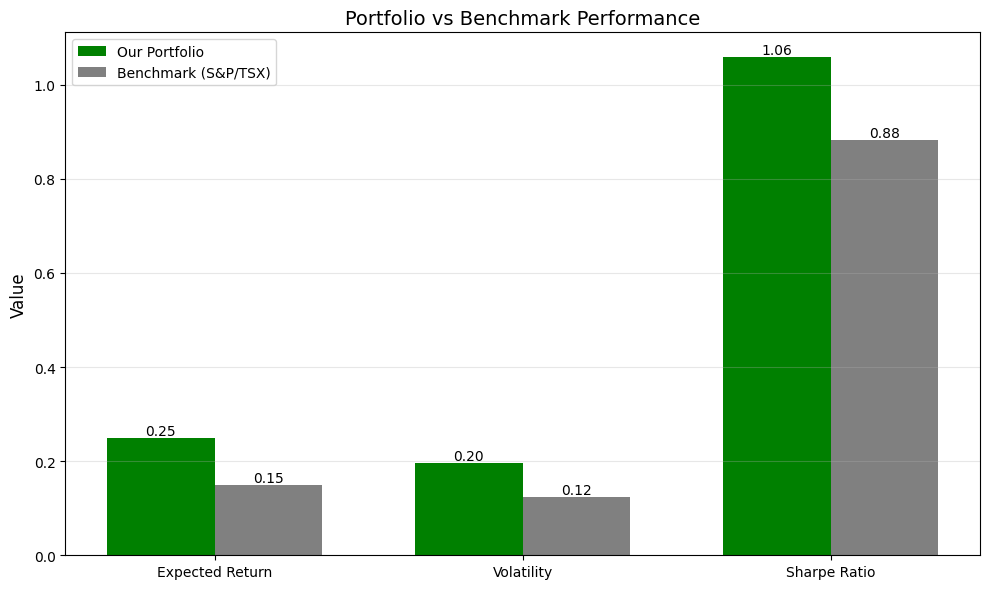

In [117]:
# Compare portfolio vs benchmark
benchmark_return = market_baseline
benchmark_vol = benchmark_returns.std() * np.sqrt(252)
benchmark_sharpe = (benchmark_return - risk_free) / benchmark_vol

categories = ['Expected Return', 'Volatility', 'Sharpe Ratio']
portfolio_vals = [expected_return, expected_volatility, sharpe_ratio]
benchmark_vals = [benchmark_return, benchmark_vol, benchmark_sharpe]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, portfolio_vals, width, label='Our Portfolio', color='green')
bars2 = ax.bar(x + width/2, benchmark_vals, width, label='Benchmark (S&P/TSX)', color='gray')

ax.set_ylabel('Value', fontsize=12)
ax.set_title('Portfolio vs Benchmark Performance', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Final Portfolio

Below is our final portfolio composed of our stocks and their weights - adding up to a 100%. You can note the final stocks, tickers, shares, investment size in each, fees and our total investment subtracting the fees.

Our calculation and code to make our final output is below as well


In [ ]:
#INVESTMENT AMOUNT
money_cad = 1000000
maxfee_usd = 2.15 
numstocks = num_stocks_to_invest

#calculating fees for a stock

def calc_fee(shares):
    fee_usd = min(2.15, shares * 0.001)
    usd_to_cad = yf.Ticker("CAD=X").fast_info["lastPrice"]
    return fee_usd * usd_to_cad

##takes dataframe with columns "Ticker" and "Weight" as a DECIMAL
def produce_finaldf(df_tickers_and_weight):

    #exchange rates for both directions
    usd_to_cad = yf.Ticker("CAD=X").fast_info["lastPrice"]
    cad_to_usd = 1 / usd_to_cad

    ### We cant know the real fee until we know the real number of shares
    ### and we cant know the real number of shares until we know how much money we are actually investing
    ### so there is a loop here where shares depend on fees and fees depend on shares

    ### so well do it twice
    ### first we pretend we invest the full 1 million before fees so we can calculate fake shares for each stock and fees for each stock and we get fees for the entire portfolio
    ### now that we  know the real total fee we subtract it from the 1 million to get the real investable amount
    ### then we calculate the real shares using that corrected amount
    ### the fees are from the first run still but because our max fees are 21.5 its safe to use the fees from the first one because there shares and fees wont be too different

    tickers = df_tickers_and_weight["Ticker"].tolist()
    weights = df_tickers_and_weight["Weight"].tolist()

    fees_listed = []
    shares_pre_fee = []
    price_listed = []
    currency_listed =[]

    for indx, row in df_tickers_and_weight.iterrows():

        ticker = row["Ticker"]
        weight_decimal = row["Weight"]

        spend_amnt_cad = money_cad * weight_decimal

        info = yf.Ticker(ticker).fast_info
        price = info["lastPrice"]
        currency = info.get("currency", "USD")

        if currency == "USD":
            price_cad = price * usd_to_cad
        else:
            price_cad = price

        shares = spend_amnt_cad / price_cad

        shares_pre_fee.append(shares)
        price_listed.append(price)
        currency_listed.append(currency)

        #fees in cad
        fees_listed.append(calc_fee(shares))

    total_fees_final = sum(fees_listed)
    total_investable_cad = money_cad - total_fees_final

    #final calcualtions for df

    final_tickers = []
    final_price = []
    final_currency = []
    final_shares = []
    final_value_cad = []
    final_weights = []
    
    for i in range(len(tickers)):
        
        ticker = tickers[i]
        weight_decimal = weights[i]
        price = price_listed[i]
        currency = currency_listed[i]

        spend_amnt_cad = total_investable_cad * weight_decimal

        if currency == "USD":
            price_cad = price * usd_to_cad
        else:
            price_cad = price

        shares = spend_amnt_cad / price_cad
        value_cad = shares * price_cad

        final_tickers.append(ticker)
        final_price.append(round(price, 2))
        final_currency.append(currency)
        final_shares.append(shares)  
        final_value_cad.append(round(value_cad,2))
        final_weights.append(round(weight_decimal * 100,2))


    df_final = pd.DataFrame({
        "Ticker": final_tickers,
        "Price": final_price,
        "Currency": final_currency,
        "Shares": final_shares,
        "Value (CAD)": final_value_cad,
        "Weight (%)": final_weights})
    
    portfolio_val = sum(final_value_cad)
    total_spend_withfees = portfolio_val + total_fees_final
    
    print("\n\nTotal Portfolio Value (CAD): $", round(portfolio_val,2))
    print("Fee Charged (CAD): $", round(total_fees_final,2))
    print("Total Spent Including Fees (CAD): $", round(total_spend_withfees,2))


    return df_final

Portfolio_Final = produce_finaldf(weights_df)
df_ticker_shares = Portfolio_Final[["Ticker", "Shares"]].copy()

total_value = Portfolio_Final["Value (CAD)"].sum()
total_weight = Portfolio_Final["Weight (%)"].sum()

#total value and total weight
summary_rows = pd.DataFrame([
    {
        "Ticker": "TOTAL VALUE",
        "Price": "",
        "Currency": "",
        "Shares": "",
        "Value (CAD)": round(total_value, 2),
        "Weight (%)": ""
    },
    {
        "Ticker": "TOTAL WEIGHT",
        "Price": "",
        "Currency": "",
        "Shares": "",
        "Value (CAD)": "",
        "Weight (%)": round(total_weight, 2)
    }])


Portfolio_Final = pd.concat([Portfolio_Final, summary_rows], ignore_index=True)
Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

display(Portfolio_Final)

df_ticker_shares.to_csv('Stocks_Group_14.csv', index=False)
print("CSV EXPORT COMPLETE")



Total Portfolio Value (CAD): $ 999889.14
Fee Charged (CAD): $ 10.87
Total Spent Including Fees (CAD): $ 999900.01


,Ticker,Price,Currency,Shares,Value (CAD),Weight (%)
1,ABX.TO,51.53,CAD,2910.894098,149998.37,15.0
2,MFC.TO,48.66,CAD,3082.580555,149998.37,15.0
3,LLY,1059.7,USD,95.858068,143198.44,14.32
4,GE,287.44,USD,308.97667,125198.64,12.52
5,CAT,550.43,USD,149.236494,115798.74,11.58
6,GOOGL,299.66,USD,247.611877,104598.86,10.46
7,BABA,152.93,USD,283.411266,61099.34,6.11
8,AVGO,340.2,USD,104.256766,49999.46,5.0
9,CRWD,490.67,USD,72.285145,49999.46,5.0
10,VERI,3.96,USD,8956.604185,49999.46,5.0


CSV EXPORT COMPLETE


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Pranay, Furqan, Aadya